<a href="https://colab.research.google.com/github/eugeneyan/visualizing-finetunes/blob/main/2_ft_fib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jul 28 09:48:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               On  | 00000000:3E:00.0 Off |                  Off |
| 30%   35C    P8              16W / 230W |      1MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# %pip install -q transformers==4.37.2 accelerate bitsandbytes datasets peft watermark

In [4]:
%load_ext watermark
%watermark --conda -p torch,transformers,peft,datasets,sklearn

torch       : 2.3.1+cu121
transformers: 4.43.1
peft        : 0.11.1
datasets    : 2.19.1
sklearn     : 1.2.2

conda environment: n/a



In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import transformers
import time
import logging

from collections import Counter
from datetime import datetime
from torch.utils.data import DataLoader, Dataset
from transformers import (
    Trainer,
    BartForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    IntervalStrategy,
)
from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_dataset
from typing import Dict, Optional, List
from sklearn.metrics import (average_precision_score,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt

In [6]:
# Set up logger
logger = logging.getLogger('2-ft-fib-only')
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    force=True
)

logger.info('Running notebook to finetune FIB')

2024-07-28 09:48:49 - INFO - Running notebook to finetune FIB


In [7]:
torch.manual_seed(555)

## Define model and tokenizer
- Note: Entailment = 2, Neutral = 1, Contradiction = 0
- https://huggingface.co/valhalla/distilbart-mnli-12-1

In [8]:
# Define model
model_id = 'valhalla/distilbart-mnli-12-3'
lora_model_id = 'lora-distilbart-mnli-12-3'

In [9]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

## Load FIB data

In [10]:
# Test loading into dataset
fib_files = {'train': './data/fib-train.csv',
             'val': './data/fib-val.csv',
             'test': './data/fib-test.csv'}

fib_ds = load_dataset('csv', data_files=fib_files)
fib_ds = fib_ds.select_columns(['input', 'list_choices', 'label'])
fib_ds = fib_ds.rename_column('input', 'premise').rename_column('list_choices', 'hypothesis')

logger.info(
    f"Label distribution - Train: {Counter(fib_ds['train']['label'])}, Val: {Counter(fib_ds['val']['label'])}, Test: {Counter(fib_ds['test']['label'])}"
)

2024-07-28 09:50:01 - INFO - Label distribution - Train: Counter({0: 350, 2: 350}), Val: Counter({0: 75, 2: 75}), Test: Counter({0: 75, 2: 75})


In [11]:
# Tokenize data in batch
def tokenize(row):
    return tokenizer(row['premise'], row['hypothesis'], truncation='only_first', padding='max_length', max_length=512)

fib_ds = fib_ds.map(tokenize, batched=True)

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [12]:
logger.info(f'FIB: {fib_ds["train"][0]["premise"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'FIB: {fib_ds["train"][0]["hypothesis"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'FIB: {fib_ds["train"][0]["input_ids"]}')
logger.info('-------------------------------------------------------------')
logger.info(f'FIB: {fib_ds["train"][0]["attention_mask"]}')

2024-07-28 09:50:01 - INFO - FIB: If you leave your mobile phone somewhere do you worry you will not be able to check it?
If any of this sounds familiar, there is a chance you could be spending too much time on social networks.
An exclusive online Newsbeat poll suggests that a quarter of 15 to 18-year-olds in the UK feel happier online than they do in real life.
Dr Radha from The Surgery on Radio 1 has dealt with patients who have displayed "a lot of social anxiety" because they are using social networks too much.
"Being online can provoke a sense of 'I'm not good enough, everyone else is having an amazing life'," she explained.
"It doesn't give us a sense of reality and actually what you will find is most people are probably doing the same thing as you are."
The survey, carried out last month, also suggests a third of 15 to 18-year-olds have met someone in person they originally met through social media.
Dr Radha has said it is important people carefully consider what information they

## Set up model

In [13]:
# Define params
LEARNING_RATE=5e-5
BATCH_SIZE=16
R=16
EPOCHS=10
EVAL_STEPS=20
LORA_DROPOUT=0.1
LORA_ALPHA=32
MAX_STEPS=-1

In [14]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
)

In [15]:
# Load model
model = BartForSequenceClassification.from_pretrained(model_id, quantization_config=bnb_config, device_map='auto', num_labels=3)

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

2024-07-28 09:51:14 - WARNING - WARNING: BNB_CUDA_VERSION=121 environment variable detected; loading libbitsandbytes_cuda121.so.
This can be used to load a bitsandbytes version that is different from the PyTorch CUDA version.
If this was unintended set the BNB_CUDA_VERSION variable to an empty string: export BNB_CUDA_VERSION=
If you use the manual override make sure the right libcudart.so is in your LD_LIBRARY_PATH
For example by adding the following to your .bashrc: export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:<path_to_cuda_dir/lib64

2024-07-28 09:51:15 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


In [16]:
# Configure lora
config = LoraConfig(
    r=R,
    lora_alpha=LORA_ALPHA,  # Keep lora alpha constant (per https://arxiv.org/abs/2305.14314) as it is proportional to learning rate
    target_modules=['k_proj', 'v_proj', 'q_proj', 'out_proj', 'fc1', 'fc2'],
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model.enable_input_require_grads()
model = get_peft_model(model, config)

In [18]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()

    trainable_prop = 100 * trainable_params / all_param

    logger.info(f"all params: {all_param:,} | trainable: {trainable_params:,} ({trainable_prop:.2f}%)")


print_trainable_parameters(model)

2024-07-28 09:54:00 - INFO - all params: 159,819,827 | trainable: 4,833,328 (3.02%)


In [19]:
# Preprocess only logits to save memory
def preprocess_logits_for_metrics(logits, labels):
    """
    Returns the probability of contradiction (aka factual inconsistency aka hallucination)
    """
    # Exclude dim = 1 on the logits, compute softmax, and get prob of the 0 label (i.e., contradiction)
    probs = F.softmax(logits[0][:, [0, 2]], dim=1)[:, 0]
    return probs


# Compute multiple metrics at once
def compute_metrics(eval_pred: transformers.EvalPrediction) -> Dict[str, float]:
    labels = eval_pred.label_ids
    probs = eval_pred.predictions
    probs_thresholded = np.where(probs >= 0.80, 1, 0)  # Assign score > 0.8 = 1 (aka contradiction)

    # Update labels so 2 (entailment) is now 0, and 0 (contradiction) is now 1 because we want to focus on the latter
    labels = np.where(labels==2, 0, 1)  # If label = 2, return 0, else, return 1

    # Compute metrics
    pr_auc = average_precision_score(labels, probs)
    roc_auc = roc_auc_score(labels, probs)
    recall = recall_score(labels, probs_thresholded)
    precision = precision_score(labels, probs_thresholded)

    return {'prauc': pr_auc, 'rocauc': roc_auc, 'recall': recall, 'precision': precision}

In [20]:
# Custom trainer to evaluate on multiple datasets
# See Trainer implementation: https://github.com/huggingface/transformers/blob/v4.31.0/src/transformers/trainer.py#L225
# See updates needed: https://github.com/huggingface/transformers/issues/20565
class CustomTrainer(Trainer):

    def __init__(self, eval_before_train=True, *args, **kwargs):
        super(CustomTrainer, self).__init__(*args, **kwargs)
        self.eval_before_train = eval_before_train

    
    def train(self, resume_from_checkpoint=None, trial=None, **kwargs):
        metrics = None
        if self.eval_before_train:
            self.state.global_step = 0
            if isinstance(self.eval_dataset, dict):
                all_metrics = {}
                for eval_dataset_name, eval_dataset in self.eval_dataset.items():
                    metrics = self.evaluate(
                        eval_dataset=eval_dataset,
                        # ignore_keys=ignore_keys_for_eval,
                        metric_key_prefix=f"eval_{eval_dataset_name}", multiple=True,
                    )
                    logger.info(f'Step 0 metrics: {metrics}')
                    for key, value in metrics.items():
                        self.log({key: value})
                    all_metrics = {**all_metrics, **metrics}
                self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, all_metrics)
                metrics = all_metrics
            else:
                metrics = self.evaluate(ignore_keys=ignore_keys_for_eval, multiple=False)
            self._report_to_hp_search(trial, self.state.global_step, metrics)
            self.eval_before_train = False

        # Call the original train method
        super(CustomTrainer, self).train(resume_from_checkpoint, trial, **kwargs)

    
    def evaluate(
        self,
        eval_dataset: Optional[Dataset] = None,
        ignore_keys: Optional[List[str]] = None,
        metric_key_prefix: str = "eval",
        multiple=False,
    ) -> Dict[str, float]:
        # memory metrics - must set up as early as possible
        self._memory_tracker.start()

        eval_dataloader = self.get_eval_dataloader(eval_dataset)
        start_time = time.time()

        eval_loop = self.prediction_loop if self.args.use_legacy_prediction_loop else self.evaluation_loop
        output = eval_loop(
            eval_dataloader,
            description="Evaluation",
            # No point gathering the predictions if there are no metrics, otherwise we defer to
            # self.args.prediction_loss_only
            prediction_loss_only=True if self.compute_metrics is None else None,
            ignore_keys=ignore_keys,
            metric_key_prefix=metric_key_prefix,
        )

        total_batch_size = self.args.eval_batch_size * self.args.world_size

        self.log(output.metrics)

        # self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, output.metrics)
        if not multiple:
            self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, output.metrics)

        self._memory_tracker.stop_and_update_metrics(output.metrics)

        return output.metrics

    
    def get_eval_dataloader(self, eval_dataset=None):
        if eval_dataset is None and isinstance(self.eval_dataset, dict):
            # handle dictionary of datasets logic here
            # for this example, let's just return the 'fib' dataset dataloader
            eval_dataset = self.eval_dataset['set']
        return super().get_eval_dataloader(eval_dataset)


    def _maybe_log_save_evaluate(self, tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval):
        if self.control.should_log:

            logs: Dict[str, float] = {}

            # all_gather + mean() to get average loss over all processes
            tr_loss_scalar = self._nested_gather(tr_loss).mean().item()

            # reset tr_loss to zero
            tr_loss -= tr_loss

            logs["loss"] = round(tr_loss_scalar / (self.state.global_step - self._globalstep_last_logged), 4)
            logs["learning_rate"] = self._get_learning_rate()

            self._total_loss_scalar += tr_loss_scalar
            self._globalstep_last_logged = self.state.global_step
            self.store_flos()

            self.log(logs)

        metrics = None
        if self.control.should_evaluate:
            if isinstance(self.eval_dataset, dict):
                all_metrics = {}
                for eval_dataset_name, eval_dataset in self.eval_dataset.items():
                    metrics = self.evaluate(
                        eval_dataset=eval_dataset,
                        ignore_keys=ignore_keys_for_eval,
                        metric_key_prefix=f"eval_{eval_dataset_name}", multiple=True,
                    )
                    all_metrics = {**all_metrics, **metrics}
                self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, all_metrics)
                metrics = all_metrics
            else:
                metrics = self.evaluate(ignore_keys=ignore_keys_for_eval, multiple=False)
            self._report_to_hp_search(trial, self.state.global_step, metrics)

        if self.control.should_save:
            self._save_checkpoint(model, trial, metrics=metrics)
            self.control = self.callback_handler.on_save(self.args, self.state, self.control)

In [21]:
%env WANDB_PROJECT=ft_fib_only

env: WANDB_PROJECT=ft_fib_only


In [22]:
import wandb

# wandb login --relogin
wandb.login()

2024-07-28 09:54:12 - ERROR - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jermyn. Use `wandb login --relogin` to force relogin


True

In [23]:
# Set training arguments
training_args = transformers.TrainingArguments(
    output_dir='./checkpoints/fib-only',
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,  # Bigger batch size for eval
    num_train_epochs=EPOCHS,
    eval_strategy='steps',
    eval_steps=EVAL_STEPS,
    gradient_accumulation_steps=4,
    optim='paged_adamw_32bit',
    bf16=False,
    max_steps=MAX_STEPS,
    save_strategy=IntervalStrategy.STEPS,
    save_steps=EVAL_STEPS,
    logging_steps=EVAL_STEPS,
    metric_for_best_model='fib_rocauc',
    greater_is_better=True,
    load_best_model_at_end=True,
    report_to="wandb",
)

In [24]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=fib_ds['train'],
#     eval_dataset=fib_ds['val'],
#     compute_metrics=compute_metrics,
#     preprocess_logits_for_metrics=preprocess_logits_for_metrics
# )

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=fib_ds['train'],
    eval_dataset={'fib': fib_ds['val']},  # Provide our eval as a dict
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    eval_before_train=True)

## Check evals before finetuning

In [25]:
fib_ds['val']

Dataset({
    features: ['premise', 'hypothesis', 'label', 'input_ids', 'attention_mask'],
    num_rows: 150
})

In [26]:
# Get predictions
fib_val_preds = trainer.predict(fib_ds['val'])[0]

# Get labels and update them so entailment = 0 and contradiction = 1
fib_val_labels = np.array(fib_ds['val']['label'])
fib_val_labels = np.where(fib_val_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

[2024-07-28 09:54:20,358] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2024-07-28 09:54:20 - INFO - gcc -pthread -B /root/miniconda3/envs/py3.11/compiler_compat -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /root/miniconda3/envs/py3.11/include -fPIC -O2 -isystem /root/miniconda3/envs/py3.11/include -fPIC -c /tmp/tmp7otcm81q/test.c -o /tmp/tmp7otcm81q/test.o
2024-07-28 09:54:20 - INFO - gcc -pthread -B /root/miniconda3/envs/py3.11/compiler_compat /tmp/tmp7otcm81q/test.o -laio -o /tmp/tmp7otcm81q/a.out


 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
 [WARNING]  using untested triton version (2.3.1), only 1.0.0 is known to be compatible


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


In [27]:
def kl_divergence(p, q):
    return np.sum(p * np.log(p / q))

def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (kl_divergence(p, m) + kl_divergence(q, m))

def visualize_preds(y, y_pred, model_name):
    df = pd.DataFrame({'label': y, 'pred_proba': y_pred})

    # Compute ROCAUC metrics
    rocauc = roc_auc_score(df['label'], df['pred_proba'])
    fpr, tpr, thresholds = roc_curve(df['label'], df['pred_proba'])
    baseline = np.sum(df['label']) / len(df)

    # Compute PRAUC metrics
    prauc = average_precision_score(df['label'], df['pred_proba'])
    prec, rec, thresholds = precision_recall_curve(df['label'], df['pred_proba'])

    # Split into consistent and inconsistent for prob distribution
    inconsistent = df[df['label'] == 1].reset_index(drop=True)
    consistent = df[df['label'] == 0].reset_index(drop=True)
    js_div = js_divergence(inconsistent['pred_proba'], consistent['pred_proba'])

    # Set up plots
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(13, 3), tight_layout=True)
    title_font_size = 10
    fig.suptitle(f'{model_name}', fontsize=title_font_size+2, y=1)

    # Plot ROC
    ax0.grid()
    ax0.plot(fpr, tpr, label='ROC')
    ax0.plot([0, 1], [0, 1], label='Random chance', linestyle='--', color='red')
    ax0.set_xlabel('False positive rate')
    ax0.set_ylabel('True positive rate')
    ax0.set_title(f'ROC AUC = {rocauc:.2f}', fontsize=title_font_size)
    ax0.legend()

    # Plot PRAUC
    ax1.grid()
    ax1.plot(rec, prec, label='PRAUC')
    ax1.axhline(y=baseline, label='Baseline', linestyle='--', color='red')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_xlim((-0.1, 1.1))
    ax1.set_ylim((-0.1, 1.1))
    ax1.set_title(f'PR AUC = {prauc:.2f}', fontsize=title_font_size)

    # Plot Precision & Recall
    ax2.grid()
    ax2.plot(thresholds, prec[1:], color='red', label='Precision')
    ax2.plot(thresholds, rec[1:], color='blue', label='Recall')
    ax2.invert_xaxis()
    ax2.set_xlabel('Thresholds (1.0 - 0.0)')
    ax2.set_ylabel('Precision / Recall')
    ax2.set_xlim((1.1, -0.1))
    ax2.set_ylim((-0.1, 1.1))
    ax2.legend()
    ax2.set_title(f'PR AUC = {prauc:.2f}', fontsize=title_font_size)

    # Plot prob distribution
    ax3.grid()
    ax3.hist(inconsistent['pred_proba'], color='red', alpha=0.5, density=True, label='Inconsistent', bins=max(int(inconsistent['pred_proba'].nunique()/20), 20))
    ax3.hist(consistent['pred_proba'], color='green', alpha=0.5, density=True, label='Consistent', bins=max(int(inconsistent['pred_proba'].nunique()/20), 20))
    ax3.set_xlabel('Prob of inconsistent')
    ax3.set_ylabel('Density')
    ax3.set_title(f'JS Divergence = {js_div:.3f}', fontsize=title_font_size)
    ax3.legend()

    plt.show()


def compute_metrics_per_threshold(y, y_pred, thresholds=[0.95, 0.90, 0.95, 0.80, 0.75, 0.70, 0.65, 0.60]):
    for threshold in thresholds:
        preds = (y_pred >= threshold).astype(int)

        recall = recall_score(y, preds)
        precision = precision_score(y, preds)
        logger.info(f'Threshold: {threshold:.2f} - Recall: {recall:.2f}, Precision: {precision:.2f}')

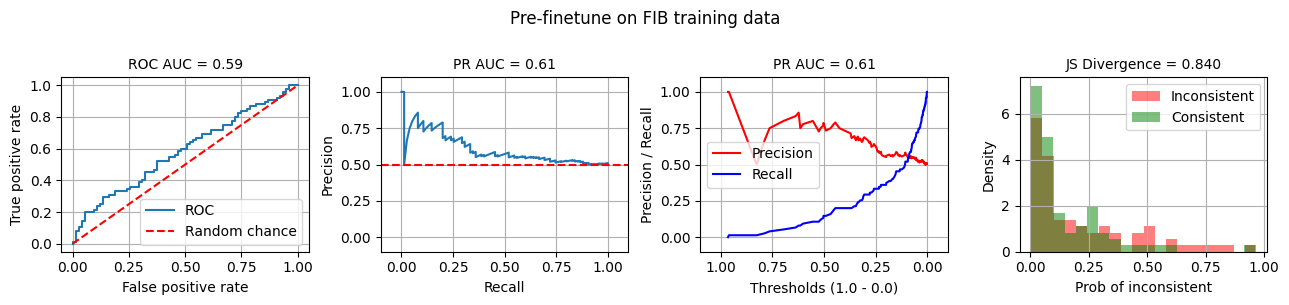

2024-07-28 09:54:30 - INFO - Threshold: 0.95 - Recall: 0.01, Precision: 0.50
2024-07-28 09:54:30 - INFO - Threshold: 0.90 - Recall: 0.01, Precision: 0.50
2024-07-28 09:54:30 - INFO - Threshold: 0.95 - Recall: 0.01, Precision: 0.50
2024-07-28 09:54:30 - INFO - Threshold: 0.80 - Recall: 0.03, Precision: 0.67
2024-07-28 09:54:30 - INFO - Threshold: 0.75 - Recall: 0.05, Precision: 0.80
2024-07-28 09:54:30 - INFO - Threshold: 0.70 - Recall: 0.05, Precision: 0.80
2024-07-28 09:54:31 - INFO - Threshold: 0.65 - Recall: 0.07, Precision: 0.83
2024-07-28 09:54:31 - INFO - Threshold: 0.60 - Recall: 0.11, Precision: 0.80


In [28]:
visualize_preds(fib_val_labels, fib_val_preds, 'Pre-finetune on FIB training data')
compute_metrics_per_threshold(fib_val_labels, fib_val_preds)

## Start finetuning

In [29]:
trainer.train()

2024-07-28 09:54:41 - INFO - Step 0 metrics: {'eval_fib_loss': 2.802734375, 'eval_fib_model_preparation_time': 0.0031, 'eval_fib_prauc': 0.6095627781271502, 'eval_fib_rocauc': 0.5854222222222221, 'eval_fib_recall': 0.02666666666666667, 'eval_fib_precision': 0.6666666666666666}


Step,Training Loss,Validation Loss,Fib Loss,Fib Model Preparation Time,Fib Prauc,Fib Rocauc,Fib Recall,Fib Precision
20,1.152500,No log,0.852539,0.003100,0.627607,0.598222,0.080000,0.750000
40,0.708200,No log,0.725586,0.003100,0.649827,0.631733,0.040000,0.750000
60,0.670300,No log,0.655762,0.003100,0.691207,0.675289,0.053333,1.000000
80,0.639000,No log,0.633789,0.003100,0.716534,0.703378,0.040000,1.000000
100,0.629700,No log,0.633301,0.003100,0.735681,0.721600,0.026667,1.000000


## Check evals after finetuning

In [30]:
def eval_fib(dataset, split='val'):
    # Get predictions
    fib_preds = trainer.predict(fib_ds[split])[0]

    # Get labels and update them so entailment = 0 and contradiction = 1
    fib_labels = np.array(fib_ds[split]['label'])
    fib_labels = np.where(fib_labels==2, 0, 1)  # If label = 2, return 0, else, return 1

    visualize_preds(fib_labels, fib_preds, f'Post-finetune on FIB training data ({split})')
    compute_metrics_per_threshold(fib_labels, fib_preds)

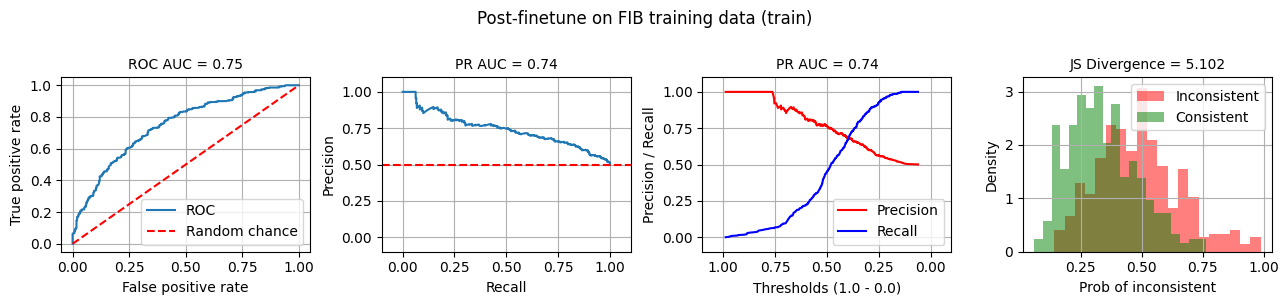

2024-07-28 10:03:03 - INFO - Threshold: 0.95 - Recall: 0.01, Precision: 1.00
2024-07-28 10:03:03 - INFO - Threshold: 0.90 - Recall: 0.02, Precision: 1.00
2024-07-28 10:03:03 - INFO - Threshold: 0.95 - Recall: 0.01, Precision: 1.00
2024-07-28 10:03:03 - INFO - Threshold: 0.80 - Recall: 0.05, Precision: 1.00
2024-07-28 10:03:03 - INFO - Threshold: 0.75 - Recall: 0.07, Precision: 0.92
2024-07-28 10:03:03 - INFO - Threshold: 0.70 - Recall: 0.10, Precision: 0.87
2024-07-28 10:03:03 - INFO - Threshold: 0.65 - Recall: 0.18, Precision: 0.88
2024-07-28 10:03:03 - INFO - Threshold: 0.60 - Recall: 0.23, Precision: 0.81


In [31]:
eval_fib(fib_ds, 'train')

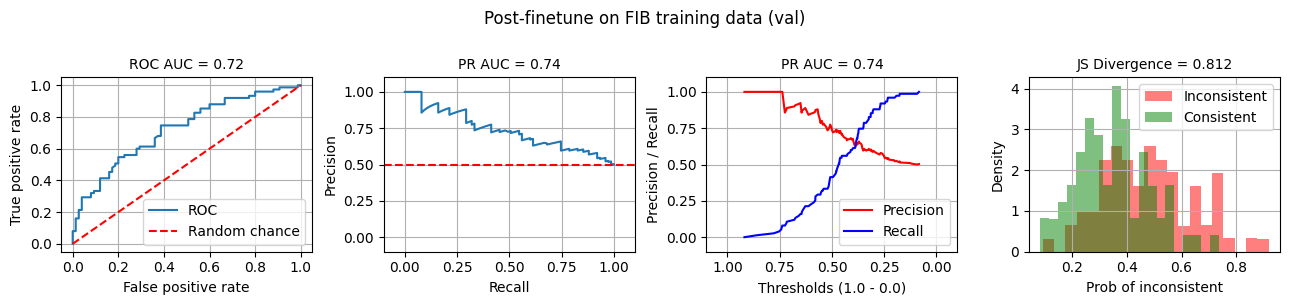

/root/miniconda3/envs/py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2024-07-28 10:03:12 - INFO - Threshold: 0.95 - Recall: 0.00, Precision: 0.00
2024-07-28 10:03:12 - INFO - Threshold: 0.90 - Recall: 0.01, Precision: 1.00
/root/miniconda3/envs/py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2024-07-28 10:03:12 - INFO - Threshold: 0.95 - Recall: 0.00, Precision: 0.00
2024-07-28 10:03:12 - INFO - Threshold: 0.80 - Recall: 0.03, Precision: 1.00
2024-07-28 10:03:12 - INFO - Threshold: 0.75 - Recall: 0.05, Precision: 1.

In [32]:
eval_fib(fib_ds, 'val')

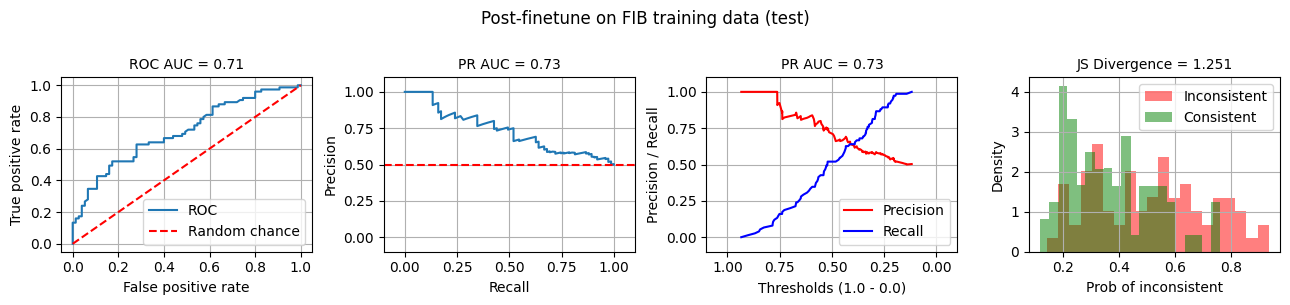

/root/miniconda3/envs/py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2024-07-28 10:03:25 - INFO - Threshold: 0.95 - Recall: 0.00, Precision: 0.00
2024-07-28 10:03:25 - INFO - Threshold: 0.90 - Recall: 0.03, Precision: 1.00
/root/miniconda3/envs/py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2024-07-28 10:03:25 - INFO - Threshold: 0.95 - Recall: 0.00, Precision: 0.00
2024-07-28 10:03:25 - INFO - Threshold: 0.80 - Recall: 0.08, Precision: 1.00
2024-07-28 10:03:25 - INFO - Threshold: 0.75 - Recall: 0.16, Precision: 0.

In [33]:
eval_fib(fib_ds, 'test')

In [34]:
# for notebooks

wandb.finish()

eval/fib_loss,██▂▁▁▁▁
eval/fib_model_preparation_time,▁▁▁▁▁▁▁
eval/fib_prauc,▁▁▂▃▆▇█
eval/fib_precision,▁▁▃▃███
eval/fib_recall,▁▁█▃▅▃▁
eval/fib_rocauc,▁▁▂▃▆▇█
test/loss,█▁▁▁
test/model_preparation_time,▁▁▁▁
test/prauc,▁██▇
test/precision,▁███
test/recall,▁▅▁█


# Next: [3_ft_usb_then_fib.ipynb](3_ft_usb_then_fib.ipynb)